In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
%matplotlib inline
RANDOM_SEED = 27
LABELS = ["Normal", "Fraud"]

In [3]:
df = pd.read_csv("creditcard.csv")

In [4]:
df2 = df.drop(['Time'], axis=1)

X_train, X_test = train_test_split(df2, test_size=0.2, random_state=RANDOM_SEED)

X_train = X_train[X_train.Class == 0]

X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)


mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [5]:
print(np.mean(X_train,axis=0))
print(np.std(X_train,axis=0))
print(np.mean(X_test,axis=0))
print(np.std(X_test,axis=0))

[-7.55191998e-17  5.43082229e-17  2.99952578e-16  4.59050524e-17
  1.18081727e-17  2.18669865e-17  1.65689281e-16 -1.07773005e-18
  2.37412996e-18  3.02732809e-16 -1.17332002e-16 -1.29327606e-17
 -9.52775841e-18 -7.74091322e-17 -2.22418491e-17  2.06174444e-18
 -2.37256804e-16 -3.98603926e-17  6.24771043e-19 -5.99155430e-17
 -4.60300066e-17 -3.69864458e-17  2.69901091e-17 -3.85483734e-17
 -3.59243350e-17 -2.47409333e-17 -2.99890101e-18  1.24329438e-17
  7.05447728e-14]
[0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978
 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978
 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978
 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978
 0.9999978]
[-9.64158338e-03  6.78752177e-03 -3.24662393e-03 -3.59966298e-03
  2.35552828e-03 -1.54444756e-03 -8.79391841e-03 -9.22211456e-04
 -7.35124705e-03 -1.33556197e-02  1.48988153e-02  9.97076818e-04
  3.49648368e-03 -9.50247775e-03  6.

In [6]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [7]:
batch_size = 100
original_dim = 29
latent_dim = 5
intermediate_dim1 = 20
intermediate_dim2 = 10
epochs = 2
epsilon_std = 1.0

In [8]:
x = Input(shape=(original_dim,), name="input")

h1 = Dense(intermediate_dim1, activation="tanh", name="encoding1", activity_regularizer=regularizers.l1(10e-5))(x)
h = Dense(intermediate_dim2, activation='relu', name="encoding")(h1)

z = Dense(latent_dim, activation='relu', name="encoder_out")(h)

encoder = Model(x, z, name="encoder")

encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 29)]              0         
                                                                 
 encoding1 (Dense)           (None, 20)                600       
                                                                 
 encoding (Dense)            (None, 10)                210       
                                                                 
 encoder_out (Dense)         (None, 5)                 55        
                                                                 
Total params: 865 (3.38 KB)
Trainable params: 865 (3.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
input_decoder = Input(shape=(latent_dim,), name="decoder_input")

decoder_h1 = Dense(intermediate_dim2, activation='relu', name="decoder_h1")(input_decoder)
decoder_h = Dense(intermediate_dim1, activation='relu', name="decoder_h")(decoder_h1)

x_decoded = Dense(original_dim, activation='tanh', name="flat_decoded")(decoder_h)

decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 5)]               0         
                                                                 
 decoder_h1 (Dense)          (None, 10)                60        
                                                                 
 decoder_h (Dense)           (None, 20)                220       
                                                                 
 flat_decoded (Dense)        (None, 29)                609       
                                                                 
Total params: 889 (3.47 KB)
Trainable params: 889 (3.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
output_combined = decoder(encoder(x))

autoencoder = Model(x, output_combined)

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 29)]              0         
                                                                 
 encoder (Functional)        (None, 5)                 865       
                                                                 
 decoder (Functional)        (None, 29)                889       
                                                                 
Total params: 1754 (6.85 KB)
Trainable params: 1754 (6.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history = autoencoder.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1).history

Epoch 1/2
2275/2275 [==============================] - 8s 3ms/step - loss: 0.7879 - accuracy: 0.2037 - val_loss: 0.7671 - val_accuracy: 0.2434
Epoch 2/2
2275/2275 [==============================] - 7s 3ms/step - loss: 0.6963 - accuracy: 0.2581 - val_loss: 0.7261 - val_accuracy: 0.2767


In [12]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
print("Full Sample",error_df.describe())
error_df_true = error_df[(error_df['true_class']== 0)]
print("Normal Sample",error_df_true.describe())
error_df_false = error_df[(error_df['true_class']== 1)]
print("Fraud Sample",error_df_false.describe())

1781/1781 [==============================] - 3s 2ms/step
Full Sample        reconstruction_error    true_class
count          56962.000000  56962.000000
mean               0.725233      0.001826
std                3.976202      0.042690
min                0.033984      0.000000
25%                0.204668      0.000000
50%                0.335469      0.000000
75%                0.575187      0.000000
max              448.236480      1.000000
Normal Sample        reconstruction_error  true_class
count          56858.000000     56858.0
mean               0.679430         0.0
std                3.590195         0.0
min                0.033984         0.0
25%                0.204434         0.0
50%                0.334958         0.0
75%                0.573041         0.0
max              448.236480         0.0
Fraud Sample        reconstruction_error  true_class
count            104.000000       104.0
mean              25.766173         1.0
std               31.526394         0.0
min   

In [13]:
from sklearn.metrics import (confusion_matrix)

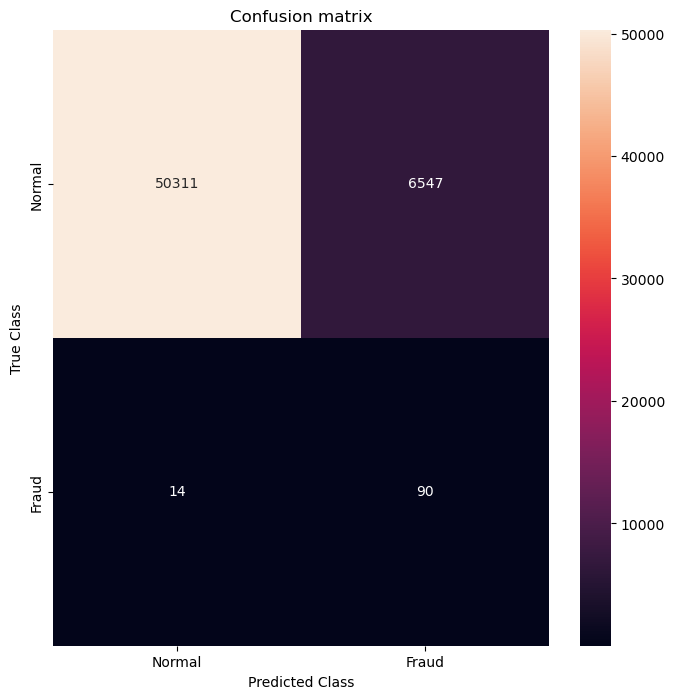

In [14]:
threshold = 0.9

groups = error_df.groupby('true_class')

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)


plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()